## BikeShare Toronto Analysis Report

The objective of this Jupyter Notebook is threefold as shown in the following bullet points. The structure of this notebook will also follow the same sections. 
1.	Short-term ridership modelling: Model the daily Bike Share ridership based on various features such as holiday, weekend, temperature, precipitation, etc. This model is appropriate for predicting the next-day ridership, given the weather forecast information is available.
2.	Long-term ridership modelling: Build a long-term ridership model to forecast the 2021 ridership without knowing the weather forecast in advance. This long-term forecast can provide insights to long-term planning activities, such as resources allocation and infrastructure investment.
3.	Bike Share dock placement: Model the ridership generation at each Bike Share station to inform the business which area needs investment in infrastructure to avoid losing ridership. 


### Section 1. Loading and Cleaning Data

In [1]:
# Load the necessary basic libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import calendar
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Load the libraries for linear regression
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import statsmodels.api as sm

# Load the libraries for neural network
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification as mc
from sklearn.svm import SVC
import time

In [2]:
# Load the 2020 dataset. 
df1 = pd.read_csv('BikeShareRidership - 2020/2020-01.csv')
df2 = pd.read_csv('BikeShareRidership - 2020/2020-02.csv')
df3 = pd.read_csv('BikeShareRidership - 2020/2020-03.csv')
df4 = pd.read_csv('BikeShareRidership - 2020/2020-04.csv')
df5 = pd.read_csv('BikeShareRidership - 2020/2020-05.csv')
df6 = pd.read_csv('BikeShareRidership - 2020/2020-06.csv')
df7 = pd.read_csv('BikeShareRidership - 2020/2020-07.csv')
df8 = pd.read_csv('BikeShareRidership - 2020/2020-08.csv')
df9 = pd.read_csv('BikeShareRidership - 2020/2020-09.csv')
df10 = pd.read_csv('BikeShareRidership - 2020/2020-10.csv')

# Clean up df10
df_dirty = df10[df10['User Type'].isnull()]
df_clean = df10[df10['User Type'].notnull()]
df_dirty['User Type'] = df_dirty['Bike Id']
df_dirty['Bike Id'] = df_dirty['End Station Name']
df_dirty['End Station Name'] = df_dirty['End Time']
df_dirty['End Time'] = df_dirty['End Station Id']
df_dirty['End Station Id'] = df_dirty['Start Station Name']
df_dirty['Start Station Name'] = df_dirty['Start Time']
df_dirty['Start Time'] = df_dirty['Start Station Id']
df_dirty['Start Station Id'] = df_dirty['Trip  Duration']

# Convert the data type of the start and end time to datetime variables, in order to calculate the missing trip duration. 
df_dirty['Start Time']  =  pd.to_datetime(df_dirty['Start Time'], format='%m/%d/%Y %H:%M')
df_dirty['End Time']  =  pd.to_datetime(df_dirty['End Time'], format='%m/%d/%Y %H:%M')
df_dirty['Trip  Duration'] = (df_dirty['End Time'] - df_dirty['Start Time']).astype('timedelta64[s]')
df_dirty.columns = ['trip_id', 'trip_duration_seconds', 'from_station_id', 'trip_start_time', 'from_station_name', \
                   'to_station_id', 'trip_stop_time', 'to_station_name', 'bike_id', 'user_type']

df11 = pd.read_csv('BikeShareRidership - 2020/2020-11.csv')
df12 = pd.read_csv('BikeShareRidership - 2020/2020-12.csv')
frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df_clean, df11, df12]
df_2020 = pd.concat(frames)

# Update the column names to be matched with other dataframes. 
df_2020.columns = ['trip_id', 'trip_duration_seconds', 'from_station_id', 'trip_start_time', 'from_station_name', \
                   'to_station_id', 'trip_stop_time', 'to_station_name', 'bike_id', 'user_type']

# Convert the data type of the start and end time to datetime variables. 
df_2020['trip_start_time']  =  pd.to_datetime(df_2020['trip_start_time'], format='%m/%d/%Y %H:%M')
df_2020['trip_stop_time']  =  pd.to_datetime(df_2020['trip_stop_time'], format='%m/%d/%Y %H:%M')

# Merge the dirty 10th month data in.
frames = [df_2020, df_dirty]
df_2020 = pd.concat(frames)

# Update the year.
df_2020['year'] = 2020

In [3]:
# Load the 2019 dataset. 
df1 = pd.read_csv('BikeShareRidership - 2019/2019-Q1.csv')
df2 = pd.read_csv('BikeShareRidership - 2019/2019-Q2.csv')
df3 = pd.read_csv('BikeShareRidership - 2019/2019-Q3.csv')
df4 = pd.read_csv('BikeShareRidership - 2019/2019-Q4.csv')
frames = [df1, df2, df3, df4]
df_2019 = pd.concat(frames)

# Convert the data type of the start and end time to datetime variables. 
df_2019['Start Time']  =  pd.to_datetime(df_2019['Start Time'], format='%m/%d/%Y %H:%M')
df_2019['End Time']  =  pd.to_datetime(df_2019['End Time'], format='%m/%d/%Y %H:%M')

# Update the column names to be matched with other dataframes. 
df_2019.columns = ['trip_id', 'trip_duration_seconds', 'from_station_id', 'trip_start_time', 'from_station_name', \
                   'to_station_id', 'trip_stop_time', 'to_station_name', 'bike_id', 'user_type']
df_2019['year'] = 2019

In [4]:
# Load the 2018 dataset. 
df1 = pd.read_csv('BikeShareRidership - 2018/Bike Share Toronto Ridership_Q1 2018.csv')
df2 = pd.read_csv('BikeShareRidership - 2018/Bike Share Toronto Ridership_Q2 2018.csv')
df3 = pd.read_csv('BikeShareRidership - 2018/Bike Share Toronto Ridership_Q3 2018.csv')
df4 = pd.read_csv('BikeShareRidership - 2018/Bike Share Toronto Ridership_Q4 2018.csv')
frames = [df1, df2, df3, df4]
df_2018 = pd.concat(frames)

# Convert the data type of the start and end time to datetime variables. 
df_2018['trip_start_time']  =  pd.to_datetime(df_2018['trip_start_time'], format='%m/%d/%Y %H:%M')
df_2018['trip_stop_time']  =  pd.to_datetime(df_2018['trip_stop_time'], format='%m/%d/%Y %H:%M')

df_2018['year'] = 2018

In [5]:
# Load the 2017 dataset. 
df1 = pd.read_csv('BikeShareRidership - 2017/Bikeshare Ridership (2017 Q1).csv')
df1['trip_start_time']  =  pd.to_datetime(df1['trip_start_time'], format='%d/%m/%Y %H:%M')
df1['trip_stop_time']  =  pd.to_datetime(df1['trip_stop_time'], format='%d/%m/%Y %H:%M')

df2 = pd.read_csv('BikeShareRidership - 2017/Bikeshare Ridership (2017 Q2).csv')
df2['trip_start_time']  =  pd.to_datetime(df2['trip_start_time'], format='%d/%m/%Y %H:%M')
df2['trip_stop_time']  =  pd.to_datetime(df2['trip_stop_time'], format='%d/%m/%Y %H:%M')

df3 = pd.read_csv('BikeShareRidership - 2017/Bikeshare Ridership (2017 Q3).csv')
df3['trip_start_time']  =  pd.to_datetime(df3['trip_start_time'], format='%m/%d/%Y %H:%M')
df3['trip_stop_time']  =  pd.to_datetime(df3['trip_stop_time'], format='%m/%d/%Y %H:%M')

df4 = pd.read_csv('BikeShareRidership - 2017/Bikeshare Ridership (2017 Q4).csv')
df4 = df4[df4.trip_stop_time != 'NULLNULL']
df4['trip_start_time']  =  pd.to_datetime(df4['trip_start_time'], format='%m/%d/%y %H:%M:%S')
df4['trip_stop_time']  =  pd.to_datetime(df4['trip_stop_time'], format='%m/%d/%y %H:%M:%S')

frames = [df1, df2, df3, df4]
df_2017 = pd.concat(frames)

df_2017['year'] = 2017

In [6]:
# Merge the dataframes into one for further analysis.
frames = [df_2017, df_2018, df_2019, df_2020]
df_total = pd.concat(frames)
df_total.head(5)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,year,bike_id
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,2017,NaN
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,2017,NaN
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,2017,NaN
3,712385,2017-01-01 00:07:00,2017-01-01 00:21:00,826.0,7077,College Park South,7010,King St W / Spadina Ave,Member,2017,NaN
4,712386,2017-01-01 00:08:00,2017-01-01 00:12:00,279.0,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member,2017,NaN


In [7]:
# df_total.to_csv('BikeShare Total Ridership.csv', index = False) 

In [8]:
# Check the data types of all variables
df_total.dtypes

trip_id                           int64
trip_start_time          datetime64[ns]
trip_stop_time           datetime64[ns]
trip_duration_seconds           float64
from_station_id                  object
from_station_name                object
to_station_id                    object
to_station_name                  object
user_type                        object
year                              int64
bike_id                          object
dtype: object

### Section 2 Descriptive Analytics

We explore the dataset through a descriptive analytics approach that carefully examines each variable included in the dataset. 

<AxesSubplot:title={'center':'Entering ridership at different time of the day between 2017 to 2020'}, xlabel='start_hour'>

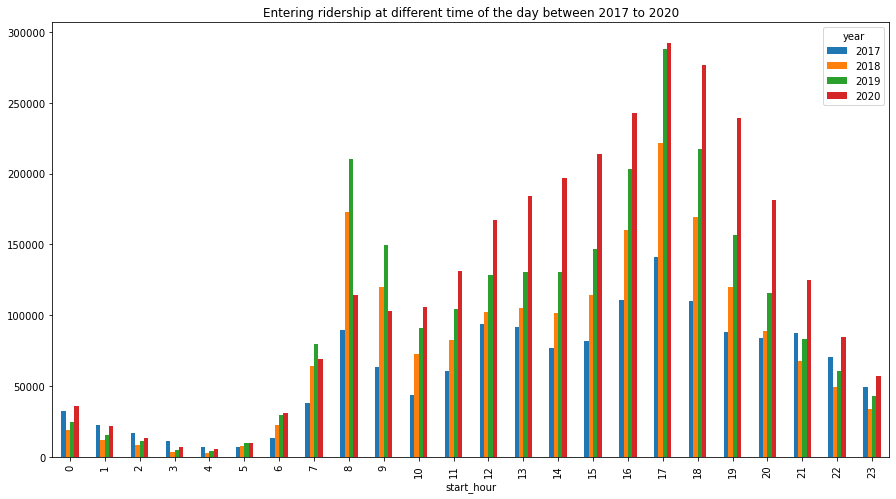

In [9]:
### Variable - Start Time 
# Extract the hour the rider enter the system
df_total['start_hour'] = df_total['trip_start_time'].dt.hour

# Count the total number of riders at different time of the day between 2017 to 2020.
starttime_pivot = df_total.pivot_table(values='trip_id', index=['year','start_hour'], aggfunc='count')
starttime_pivot = starttime_pivot.reset_index()

# Plot the grouped bar chart. 
starttime_pivot.pivot(index='start_hour', columns='year', \
                      values='trip_id').plot(kind='bar', figsize = (15,8), title = 'Entering ridership at different time of the day between 2017 to 2020')

<AxesSubplot:title={'center':'Exiting ridership at different time of the day between 2017 to 2020'}, xlabel='leave_hour'>

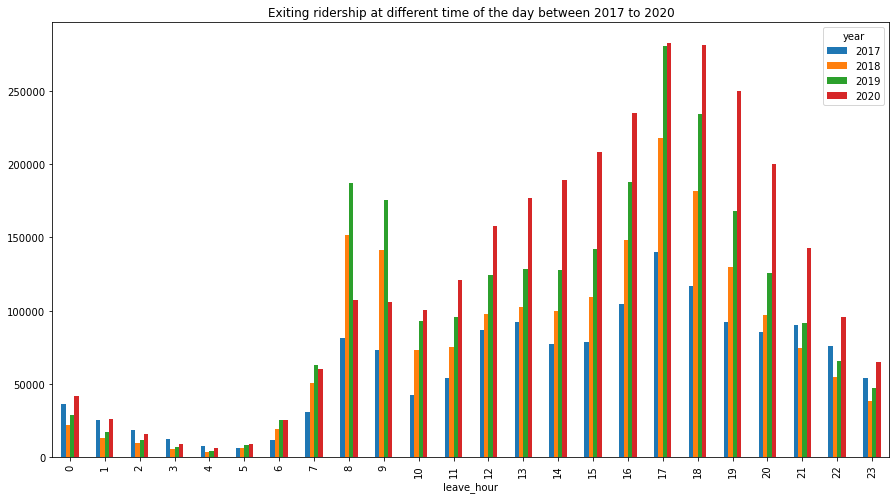

In [10]:
### Variable - End Time
# Extract the hour the rider leave the system
df_total['leave_hour'] = df_total['trip_stop_time'].dt.hour

# Count the total number of riders at different time of the day between 2017 to 2020.
stoptime_pivot = df_total.pivot_table(values='trip_id', index=['year','leave_hour'], aggfunc='count')
stoptime_pivot = stoptime_pivot.reset_index()

# Plot the grouped bar chart. 
stoptime_pivot.pivot(index='leave_hour', columns='year', \
                      values='trip_id').plot(kind='bar', figsize = (15,8), title = 'Exiting ridership at different time of the day between 2017 to 2020')

In [11]:
### Trip Duration
# Average trip duration in each year.
duration_pivot = df_total.pivot_table(values='trip_duration_seconds', index=['year'], aggfunc = np.mean)
duration_pivot = duration_pivot.reset_index()
duration_pivot

,year,trip_duration_seconds
0,2017,1017.616609
1,2018,962.976018
2,2019,1044.853495
3,2020,1170.802402


<AxesSubplot:title={'center':'Average Trip Duation Every Month between 2017 to 2020'}, xlabel='month'>

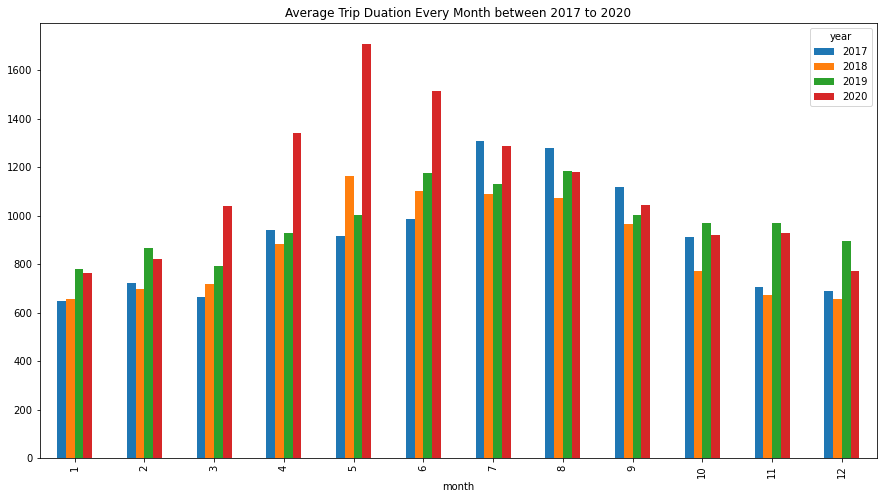

In [12]:
# Extract the month the rider enters the system
df_total['month'] = df_total['trip_start_time'].dt.month

# Caluclate the average trip duration in each month.
avgduration_pivot = df_total.pivot_table(values='trip_duration_seconds', index=['year','month'], aggfunc = np.mean)
avgduration_pivot = avgduration_pivot.reset_index()

# Plot the grouped bar chart. 
avgduration_pivot.pivot(index='month', columns='year', \
                      values='trip_duration_seconds').plot(kind='bar', figsize = (15,8), title = 'Average Trip Duation Every Month between 2017 to 2020')

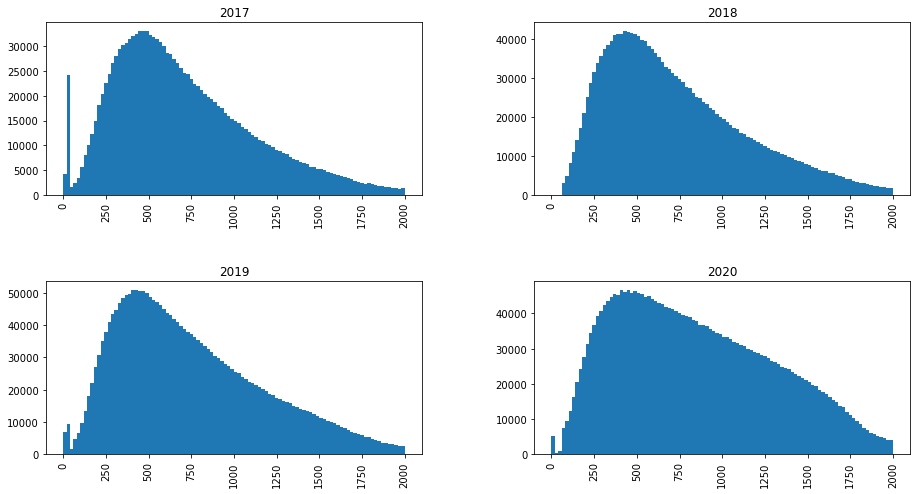

In [13]:
# df_total['trip_duration_seconds'].hist(by=df_total['year'], figsize = (15,8), range=[0, 2000], bins =100, title = 'Distribution of trip duration between 2017 to 2020')
ax = df_total['trip_duration_seconds'].hist(by=df_total['year'], figsize = (15,8), range=[0, 2000], bins =100)

In [14]:
# Number of stations in each year
df_total.head(5)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,year,bike_id,start_hour,leave_hour,month
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,2017,NaN,0,0,1
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,2017,NaN,0,0,1
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,2017,NaN,0,0,1
3,712385,2017-01-01 00:07:00,2017-01-01 00:21:00,826.0,7077,College Park South,7010,King St W / Spadina Ave,Member,2017,NaN,0,0,1
4,712386,2017-01-01 00:08:00,2017-01-01 00:12:00,279.0,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member,2017,NaN,0,0,1


In [15]:
# Number of active stations in each year
from_station = df_total[['from_station_id', 'from_station_name', 'year']]
to_station = df_total[['to_station_id', 'to_station_name', 'year']]

from_station['activity'] = 'Origin'
from_station.columns = ['station_id','station_name','year','activity']

to_station['activity'] = 'Destination'
to_station.columns = ['station_id','station_name','year','activity']

frames = [from_station, to_station]
stations_df = pd.concat(frames)

stations_df.head(5)

,station_id,station_name,year,activity
0,7051,Wellesley St E / Yonge St Green P,2017,Origin
1,7143,Kendal Ave / Bernard Ave,2017,Origin
2,7113,Parliament St / Aberdeen Ave,2017,Origin
3,7077,College Park South,2017,Origin
4,7079,McGill St / Church St,2017,Origin


In [16]:
### Identify the stations with highest shared bike traffic in each year. 
stations_2017 = stations_df[stations_df['year'] == 2017]
stations_2018 = stations_df[stations_df['year'] == 2018]
stations_2019 = stations_df[stations_df['year'] == 2019]
stations_2020 = stations_df[stations_df['year'] == 2020]

top_stations_2017 = stations_2017.pivot_table(values='activity', index=['station_name'], \
                                              aggfunc = 'count').sort_values('activity', ascending=False)
top_stations_2017 = top_stations_2017.reset_index()
top_stations_2018 = stations_2018.pivot_table(values='activity', index=['station_name'], \
                                              aggfunc = 'count').sort_values('activity', ascending=False)
top_stations_2018 = top_stations_2018.reset_index()
top_stations_2019 = stations_2019.pivot_table(values='activity', index=['station_name'], \
                                              aggfunc = 'count').sort_values('activity', ascending=False)
top_stations_2019 = top_stations_2019.reset_index()
top_stations_2020 = stations_2020.pivot_table(values='activity', index=['station_name'], \
                                              aggfunc = 'count').sort_values('activity', ascending=False)
top_stations_2020 = top_stations_2020.reset_index()

top_stations_2017.to_csv('top_stations_2017.csv', index = False) 
top_stations_2018.to_csv('top_stations_2018.csv', index = False) 
top_stations_2019.to_csv('top_stations_2019.csv', index = False) 
top_stations_2020.to_csv('top_stations_2020.csv', index = False) 

pd.concat([top_stations_2017.head(10), top_stations_2018.head(10), top_stations_20197.head(10), top_stations_20207.head(10)], axis=1)

NameError: name 'top_stations_20187' is not defined

In [ ]:
# Calculate the total number of available stations between 2017 - 2020. 
num_stations = stations_df.groupby('year')['station_id'].nunique()
num_stations = pd.DataFrame({'year':num_stations.index, 'num_stations':num_stations.values})

# Calculate the total number of visits per station between 2017 - 2020.
num_stations_v0 = stations_df.pivot_table(values='activity', index=['year'], aggfunc = 'count')
num_stations_v0 = num_stations_v0.reset_index()

num_stations = pd.merge(num_stations_v0, num_stations, on = 'year', how='inner')

num_stations['ridership_perday'] = num_stations['activity']/(2*365)
num_stations['avg_visits_perday'] = round(num_stations['activity']/(num_stations['num_stations']*365),2)
num_stations

In [ ]:
# User Type
# Calculate the total usage of different membership types between 2017 - 2020.
df_total['monthly_index'] = (df_total['year']-2017)*12 + df_total['month']
user_type = df_total.pivot_table(values='trip_id', index=['monthly_index', 'user_type'], aggfunc = 'count')
user_type = user_type.reset_index()

user_type

In [ ]:
user_type.loc[user_type['user_type'] == 'Casual', 'user_type'] = 'Casual Member' 
user_type.loc[user_type['user_type'] == 'Member', 'user_type'] = 'Annual Member' 

user_type

In [ ]:
# Plot the grouped bar chart. 
user_type.pivot(index='monthly_index', columns='user_type', \
                      values='trip_id').plot(kind='bar', figsize = (15,8), title = 'Ridership split based on membership type between 2017 to 2020')

### Section 2 Long-term ridership modelling

Build a long-term ridership model to forecast the 2021 ridership without knowing the weather forecast in advance. This long-term forecast can provide insights to long-term planning activities, such as resources allocation and infrastructure investment.

In [ ]:
df_total.head(5)

In [ ]:
# Make the membership type consistent in the df_total.
df_total.loc[df_total['user_type'] == 'Casual', 'user_type'] = 'Casual Member' 
df_total.loc[df_total['user_type'] == 'Member', 'user_type'] = 'Annual Member' 

# Count the ridership 
ridership_df = df_total.pivot_table(values='trip_id', index=['year', 'month','user_type'], aggfunc = 'count')
ridership_df = ridership_df.reset_index()
ridership_df['date'] = pd.to_datetime((ridership_df.year*10000+ridership_df.month*100+1).apply(str),format='%Y%m%d')

# Split the ridership dataframe into member and casual riderships
member_ridership = ridership_df[ridership_df['user_type'] == 'Annual Member']
casual_ridership = ridership_df[ridership_df['user_type'] == 'Casual Member']

# Assign the first day of the month as the date. 
member_ridership['date'] = pd.to_datetime((member_ridership.year*10000+member_ridership.month*100+1).apply(str),format='%Y%m%d')
casual_ridership['date'] = pd.to_datetime((casual_ridership.year*10000+casual_ridership.month*100+1).apply(str),format='%Y%m%d')

In [ ]:
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(member_ridership.date, member_ridership.trip_id, label = "Member")
plt.plot(casual_ridership.date, casual_ridership.trip_id, label = "Casual")
plt.xlabel('Month')
# Set the y axis label of the current axis.
plt.ylabel('Ridership')
# Set a title of the current axes.
plt.title('Monthly Member vs Casual Ridership between 2017 and 2020')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
### Obtain the number of active stations in each month
# Extract only the station information
from_station = df_total[['from_station_id', 'from_station_name', 'year', 'month']]
to_station = df_total[['to_station_id', 'to_station_name', 'year', 'month']]

# Identify the activity of using the specfic station. 
from_station['activity'] = 'Origin'
from_station.columns = ['station_id','station_name','year','month','activity']
to_station['activity'] = 'Destination'
to_station.columns = ['station_id','station_name','year','month','activity']

# Merge the two dataframes together. 
frames = [from_station, to_station]
stations_df = pd.concat(frames)

# Get the number of stations that have bike share activities each month.
num_stations_month = stations_df.groupby(['year', 'month'])['station_name'].nunique()
num_stations_month = pd.DataFrame({'year':num_stations_month.index.get_level_values('year'), \
                                   'month':num_stations_month.index.get_level_values('month'), \
                                   'num_stations':num_stations_month.values})

# Make sure the number of stations in the later months is higher than the previous months.
station_count = num_stations_month['num_stations']
station_count2 = []
a = []
for i in station_count:
    a.append(i)
    station_count2.append(max(a))
    
# Assuming that almost all stations have at least one bike share activity each month
# Then this will give us the actual number of stations each month. 
num_stations_month['actual_num_stations'] = station_count2

del num_stations_month['num_stations']

member_ridership = pd.merge(member_ridership, num_stations_month, on = ['year', 'month'], how='inner')
casual_ridership = pd.merge(casual_ridership, num_stations_month, on = ['year', 'month'], how='inner')

# Clean up the unnecessary columns.
del member_ridership['user_type']
del member_ridership['date']
del casual_ridership['user_type']
del casual_ridership['date']

member_ridership['month'] = member_ridership['month'].apply(lambda x: calendar.month_abbr[x])
casual_ridership['month'] = casual_ridership['month'].apply(lambda x: calendar.month_abbr[x])

# Formulate the dataframe for long term member ridership forecasting. 
long_term_member_df = pd.get_dummies(member_ridership)
long_term_casual_df = pd.get_dummies(casual_ridership)

# Create one-year lag variable.
long_term_member_df['one_year_lag'] = long_term_member_df.trip_id.shift(12)
long_term_member_df.one_year_lag.fillna(long_term_member_df.trip_id, inplace=True)
long_term_casual_df['one_year_lag'] = long_term_casual_df.trip_id.shift(12)
long_term_casual_df.one_year_lag.fillna(long_term_casual_df.trip_id, inplace=True)

In [ ]:
### Cross validating the regression model for long-term member ridership
X = long_term_member_df.iloc[:, 2:]
X['const'] = 1
y = long_term_member_df.iloc[:, 1]

model = LinearRegression()
R2s = []
RMSEs = []
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train])
    # Obtain the R squared score
    score = model.score(X.iloc[test,:], y.iloc[test])
    R2s.append(score)
    
    # Obtain the RMSE of the model
    y_pred = model.predict(X.iloc[test,:])
    rms = mean_squared_error(y.iloc[test], y_pred, squared=False)
    RMSEs.append(rms)
print("The R squared of k-fold cross validation scores are:", R2s)
print("The RMSE of k-fold cross validation scores are:", RMSEs)

In [ ]:
# Since the prediction accuracy is pretty good as shown in the cross validation, 
# We proceed to use the whole dataset to generate a model for long-term ridership prediction. 

long_term_member_model = sm.OLS(y, X)
results_long_member = long_term_member_model.fit()
print(results_long_member.summary())

In [ ]:
### Cross validating the regression model for long-term member ridership
X = long_term_casual_df.iloc[:, 2:]
X['const'] = 1
y = long_term_casual_df.iloc[:, 1]

model = LinearRegression()
R2s = []
RMSEs = []
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train])
    # Obtain the R squared score
    score = model.score(X.iloc[test,:], y.iloc[test])
    R2s.append(score)
    
    # Obtain the RMSE of the model
    y_pred = model.predict(X.iloc[test,:])
    rms = mean_squared_error(y.iloc[test], y_pred, squared=False)
    RMSEs.append(rms)
print("The R squared of k-fold cross validation scores are:", R2s)
print("The RMSE of k-fold cross validation scores are:", RMSEs)

In [ ]:
# Since the prediction accuracy is pretty good as shown in the cross validation, 
# We proceed to use the whole dataset to generate a model for long-term ridership prediction. 

long_term_casual = sm.OLS(y, X)
results_long_casual = long_term_casual.fit()
print(results_long_casual.summary())

### Section 3. Short-term ridership modelling

Model the daily Bike Share ridership based on various features such as holiday, weekend, temperature, precipitation, etc. This model is appropriate for predicting the next-day ridership, given the weather forecast information is available.

In [ ]:
# Convert the datetime variable to date for pivotting. 
df_total['date'] = df_total['trip_start_time'].dt.date
daily_ridership = df_total.pivot_table(values='trip_id', index=['date', 'user_type'], aggfunc='count')
daily_ridership = daily_ridership.reset_index()

### Adding attributes into the dataframe. 
## Add the month and year variable to be inner joined with the num_stations_month dataframe. 
daily_ridership['month'] = pd.DatetimeIndex(daily_ridership['date']).month
daily_ridership['year'] = pd.DatetimeIndex(daily_ridership['date']).year
daily_ridership = pd.merge(daily_ridership, num_stations_month, on = ['year','month'], how='inner')

## Add weather variables into the dataframe
# Load the weather dataset
w2017 = pd.read_csv('Toronto Weather Data/TorontoWeather2017.csv', skiprows=1)
w2018 = pd.read_csv('Toronto Weather Data/TorontoWeather2018.csv', skiprows=1)
w2019 = pd.read_csv('Toronto Weather Data/TorontoWeather2019.csv', skiprows=1)
w2020 = pd.read_csv('Toronto Weather Data/TorontoWeather2020.csv')

# Concatenate all four dataframes
frames = [w2017, w2018, w2019, w2020]
toronto_weather = pd.concat(frames)

# Clean up the dataframes and convert the date variable from object to proper date type
toronto_weather = toronto_weather.drop(['wdir', 'wpgt','pres','tsun'], axis = 1)
toronto_weather = toronto_weather.fillna(0)
toronto_weather['date'] = toronto_weather['date'].astype('datetime64[ns]').dt.date

daily_ridership = pd.merge(daily_ridership, toronto_weather, on = ['date'], how='inner')

# Convert month into strings. 
daily_ridership['str_month'] = daily_ridership['month'].apply(lambda x: calendar.month_abbr[x])

daily_ridership.head(5)

In [ ]:
# Split the daily ridership dataframe into casual members and annual members. 
daily_ridership_casual = daily_ridership[daily_ridership['user_type'] == 'Casual Member']
daily_ridership_casual['weekday'] = ((pd.DatetimeIndex(daily_ridership_casual.date).dayofweek) // 5 == 1).astype(float)
daily_ridership_casual = daily_ridership_casual.drop(['user_type', 'month', 'year','date'], axis = 1)

# Create one-day lag variable.
daily_ridership_casual['one_day_lag'] = daily_ridership_casual.trip_id.shift(1)
daily_ridership_casual.one_day_lag.fillna(daily_ridership_casual.trip_id, inplace=True)

daily_ridership_member = daily_ridership[daily_ridership['user_type'] == 'Annual Member']
daily_ridership_member['weekday'] = ((pd.DatetimeIndex(daily_ridership_member.date).dayofweek) // 5 == 1).astype(float)
daily_ridership_member = daily_ridership_member.drop(['user_type', 'month', 'year', 'date'], axis = 1)

# Create one-day lag variable.
daily_ridership_member['one_day_lag'] = daily_ridership_member.trip_id.shift(1)
daily_ridership_member.one_day_lag.fillna(daily_ridership_member.trip_id, inplace=True)

# Formulate the dataframe for regression. 
short_term_casual_regression = pd.get_dummies(daily_ridership_casual)
short_term_casual_regression['constant'] = 1
short_term_casual_regression = short_term_casual_regression.drop(['str_month_Jan'], axis = 1)
short_term_member_regression = pd.get_dummies(daily_ridership_member)
short_term_member_regression['constant'] = 1
short_term_member_regression = short_term_member_regression.drop(['str_month_Jan'], axis = 1)

short_term_casual_regression.head(5)

In [ ]:
X = short_term_casual_regression.iloc[:, 1:]
y = short_term_casual_regression.iloc[:, 0]

model = LinearRegression()
R2s = []
RMSEs = []
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train])
    # Obtain the R squared score
    score = model.score(X.iloc[test,:], y.iloc[test])
    R2s.append(score)
    
    # Obtain the RMSE of the model
    y_pred = model.predict(X.iloc[test,:])
    rms = mean_squared_error(y.iloc[test], y_pred, squared=False)
    RMSEs.append(rms)
print("The R squared of k-fold cross validation scores are:", R2s)
print("The RMSE of k-fold cross validation scores are:", RMSEs)

In [ ]:
# Since the prediction accuracy is pretty good as shown in the cross validation, 
# We proceed to use the whole dataset to generate a model for long-term ridership prediction. 

short_term_model = sm.OLS(y, X)
results_short = short_term_model.fit()
print(results_short.summary())

In [ ]:
X = short_term_member_regression.iloc[:, 1:]
y = short_term_member_regression.iloc[:, 0]

model = LinearRegression()
R2s = []
RMSEs = []
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train])
    # Obtain the R squared score
    score = model.score(X.iloc[test,:], y.iloc[test])
    R2s.append(score)
    
    # Obtain the RMSE of the model
    y_pred = model.predict(X.iloc[test,:])
    rms = mean_squared_error(y.iloc[test], y_pred, squared=False)
    RMSEs.append(rms)
print("The R squared of k-fold cross validation scores are:", R2s)
print("The RMSE of k-fold cross validation scores are:", RMSEs)

In [ ]:
# Since the prediction accuracy is pretty good as shown in the cross validation, 
# We proceed to use the whole dataset to generate a model for long-term ridership prediction. 

short_term_model = sm.OLS(y, X)
results_short = short_term_model.fit()
print(results_short.summary())

### Step 4. Bike Share Dock Planning

In [ ]:
def onelistmaker(n):
    listofzeros = [1] * n
    return listofzeros

month_values = onelistmaker(12)

X = long_term_member_df.iloc[:,2:15]

# Create monthly dummy variables.
X_pred = pd.DataFrame(np.diag(month_values),index=list(X.columns)[1:],columns=list(X.columns)[1:])
X_pred = X_pred.reset_index()
X_pred['const'] = 1
del X_pred['index']

# Create the preliminary station counts
station_num_int = 620
X_pred[list(X.columns)[0]] = station_num_int
X_increment = X_pred.copy()

while station_num_int <= 900:
    station_num_int += 50
    X_increment[list(X.columns)[0]] = station_num_int
    frames = [X_increment, X_pred]
    X_pred = pd.concat(frames)
    
# Place the yearly lagged variable into the X_pred dataframe
prev_year_ridership = list(long_term_member_df[long_term_member_df['year'] == 2020]['trip_id'])
months = []
for i in range(12):
    months.append(i+1)
d = {'month': months, 'one_year_lag': prev_year_ridership}
lag_df = pd.DataFrame(data=d)
lag_df['month'] = lag_df['month'].apply(lambda x: calendar.month_abbr[x])
lag_df_final = pd.get_dummies(lag_df)
X_pred = pd.merge(X_pred, lag_df_final, on = list(lag_df_final.columns)[1:], how='inner')

# Rearrange the order of columns.
X_pred = X_pred[['actual_num_stations', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
       'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov',
       'month_Oct', 'month_Sep', 'one_year_lag','const']]

X_pred.head(5)

In [ ]:
y_pred_member = results_long_member.predict(X_pred)
y_pred_casual = results_long_casual.predict(X_pred)

X_pred['predicted_member_ridership'] = y_pred_member
X_pred['predicted_casual_ridership'] = y_pred_casual
X_pred['predicted_ridership'] = X_pred['predicted_casual_ridership']+ X_pred['predicted_member_ridership']

X_pred['month_Apr'] = X_pred['month_Apr']*4
X_pred['month_Dec'] = X_pred['month_Dec']*12
X_pred['month_Aug'] = X_pred['month_Aug']*8
X_pred['month_Feb'] = X_pred['month_Feb']*2
X_pred['month_Jul'] = X_pred['month_Jul']*7
X_pred['month_Jun'] = X_pred['month_Jun']*6
X_pred['month_Mar'] = X_pred['month_Mar']*3
X_pred['month_May'] = X_pred['month_May']*5
X_pred['month_Nov'] = X_pred['month_Nov']*11
X_pred['month_Oct'] = X_pred['month_Oct']*10
X_pred['month_Sep'] = X_pred['month_Sep']*9
X_pred['month'] = X_pred.iloc[:, 1:13].sum(axis=1)

X_pred.head(5)

In [ ]:
X_pred_filtered = X_pred[['actual_num_stations','month','predicted_ridership']]
plot_df = X_pred_filtered.pivot(index='month', columns='actual_num_stations', values='predicted_ridership')
plot_df.plot()

It often surprises city officials to learn that a typical cost for a docked system is around $US6,000–$US10,000 per bike, including docking infrastructure. Using 1.26 exchange rate on 2021-07-21, assuming installation cost is $US7,000 per bike and there are 10 bikes stored on each docking station, each dock will cost $CA 88,200

In [ ]:
X_pred_profitability = X_pred[['actual_num_stations','month','predicted_ridership']]

# Calculate the revenue from ridership
X_pred_profitability['estimate_revenue'] = X_pred_profitability['predicted_ridership']*3.25

profitablity_df = X_pred_profitability.pivot_table(values='estimate_revenue', index=['actual_num_stations'], aggfunc=np.sum)
profitablity_df = profitablity_df.reset_index()

profitablity_df['installation cost'] = (profitablity_df['actual_num_stations']-620)*88200
profitablity_df['profit'] = profitablity_df['estimate_revenue'] - profitablity_df['installation cost']
profitablity_df